In [1]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np
import seaborn as sns
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from IPython.display import display, HTML
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import warnings
# warnings.filterwarnings('ignore')

In [2]:
def extracting(df):
    df.drop(['link'], axis=1, inplace=True)

    df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x))
    df['genres'] = df['genres'].apply(lambda x: sorted(x))
    df['genres'] = df['genres'].apply(lambda x: ','.join(x))
    
    return df

In [3]:
def string_to_num(X_train, X_val, X_test, col):
    # Khởi tạo Label Encoder
    le = LabelEncoder()
    
    for i in X_test[col].unique():
        if i not in X_train[col].unique():
            X_test[col].replace(i, 'Unknown', inplace=True)
    for i in X_val[col].unique():
        if i not in X_train[col].unique():
            X_val[col].replace(i, 'Unknown', inplace=True)

    data = np.append(np.array(X_train[col].copy()), 'Unknown')
    le.fit(data)
    X_train[col] = le.transform(X_train[col])
    X_val[col] = le.transform(X_val[col])
    X_test[col] = le.transform(X_test[col])

    return X_train, X_val, X_test

In [4]:
def fillMissingData(data_train, data_val, data_test):
    eod_columns = ['publish_year', 'num_pages', 'page_format', 'publisher_count']
    eod_values = [data_train[col].mean() + 3*data_train[col].std() for col in eod_columns]
    for col, val in zip(eod_columns, eod_values):
        data_train[col].fillna(val, inplace=True)
        data_val[col].fillna(val, inplace=True)
        data_test[col].fillna(val, inplace=True)
    return data_train, data_val, data_test

In [5]:
def plotDistribution(data, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes] 
    for col, ax in zip(columns, axes):
        ax.hist(data[col], bins=50)
        ax.set_title(col)
    plt.show()
    # fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    # if isinstance(axes, np.ndarray):
    #     axes = axes.flatten()
    # else:
    #     axes = [axes]
    # for col, ax in zip(columns, axes):
    #     sns.histplot(data[col], ax=ax, bins=50)
    #     ax.set_title(col)
    # plt.show()
    

def plotScatter(data, columns, target):
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    for col, ax in zip(columns, axes):
        ax.scatter(data[col], data[target])
        ax.set_title(col)
    plt.show()

def plotBar(data, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    for col, ax in zip(columns, axes):
        ax.bar(data[col].value_counts().index, data[col].value_counts())
        ax.set_title(col)
    plt.show()

def plotHeatmap(data, columns):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(data[columns].corr())
    plt.xticks(range(len(columns)), columns, rotation=90)
    plt.yticks(range(len(columns)), columns)
    plt.show()

def plotBox(data, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]
    for col, ax in zip(columns, axes):
        ax.boxplot(data[col])
        ax.set_title(col)
    plt.show()

In [6]:
def printDescription(data, columns):
    for col in columns:
        print(data[col].describe())

In [7]:
skewedDists = ['ratings_count', 'reviews_count', 'publish_year', 'num_pages', 'Fiction', 'Classics', 'Adventure',
       'Mystery', 'Historical Fiction', 'Literature', 'Paranormal', 'Historical', 'Science Fiction', 'Thriller', 
       'Magic', 'Nonfiction', 'Childrens', 'title_count', 'publisher_count', 'rating_review_ratio', 'books_by_author', 'title_length']
isUpper_bridge = [True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
skewedDists = {col: isUpper_bridge for col, isUpper_bridge in zip(skewedDists, isUpper_bridge)}
gaussionDists = []
isUpper_boundary = []
gaussionDists = {col: isUpper_boundary for col, isUpper_boundary in zip(gaussionDists, isUpper_boundary)}

In [8]:
def outliers_handle(data, variable, isShow=False):
    upper_boundary=data[variable].mean() + 3 * data[variable].std()
    lower_boundary=data[variable].mean() - 3 * data[variable].std()
    if isShow:
        print(f"upper_boundary: {upper_boundary}")
        print(f"lower_boundary: {lower_boundary}")
        print(f"mean: {data[variable].mean()}")
    return lower_boundary, upper_boundary

def outliers_handle_skewed(data, variable, isShow=False):
    IQR=data[variable].quantile(0.75) - data[variable].quantile(0.25)
    lower_bridge=data[variable].quantile(0.25) - (IQR*3)
    upper_bridge=data[variable].quantile(0.75) + (IQR*3)
    if isShow:
        print(f"lower_bridge: {lower_bridge}")
        print(f"upper_bridge: {upper_bridge}")
    return lower_bridge, upper_bridge

In [9]:
minMaxScaler = MinMaxScaler()
maxAbsScaler = MaxAbsScaler()
standardScaler = StandardScaler()
robustScaler = RobustScaler()
normalizer = Normalizer()
quantileTransformer = QuantileTransformer()
powerTransformer = PowerTransformer()
scalerArr = [minMaxScaler, maxAbsScaler, standardScaler, robustScaler, normalizer, quantileTransformer, powerTransformer]

In [10]:
def scaleData(data_train, data_val, data_test, scaler):
    scaler.fit(data_train)
    data_train = pd.DataFrame(scaler.transform(data_train.copy()), columns=data_train.columns)
    data_val = pd.DataFrame(scaler.transform(data_val.copy()), columns=data_val.columns)
    data_test = pd.DataFrame(scaler.transform(data_test.copy()), columns=data_test.columns)
    return data_train, data_val, data_test

In [11]:
def handleOutlier(data_train, data_val, data_test):
    for col in skewedDists:
        lower_bridge, upper_bridge = outliers_handle_skewed(data_train, col)
        if skewedDists[col]:
            data_train.loc[data_train[col]>=upper_bridge,col]=upper_bridge
            data_val.loc[data_val[col]>=upper_bridge,col]=upper_bridge
            data_test.loc[data_test[col]>=upper_bridge,col]=upper_bridge
        else:
            data_train.loc[data_train[col]<=lower_bridge,col]=lower_bridge
            data_val.loc[data_val[col]<=lower_bridge,col]=lower_bridge
            data_test.loc[data_test[col]<=lower_bridge,col]=lower_bridge
        
    for col in gaussionDists:
        lower_boundary, upper_boundary = outliers_handle(data_train, col)
        if gaussionDists[col]:
            data_train.loc[data_train[col]>=upper_boundary,col]=upper_boundary
            data_val.loc[data_val[col]>=upper_boundary,col]=upper_boundary
            data_test.loc[data_test[col]>=upper_boundary,col]=upper_boundary
        else:
            data_train.loc[data_train[col]<=lower_boundary,col]=lower_boundary
            data_val.loc[data_val[col]<=lower_boundary,col]=lower_boundary
            data_test.loc[data_test[col]<=lower_boundary,col]=lower_boundary
    return data_train, data_val, data_test

In [12]:
def selectFeatures(X_train, y_train, X_val, X_test):
    estimator = SVR(kernel="linear")
    selector = RFE(estimator, n_features_to_select=16, step=1)
    selector = selector.fit(X_train, y_train)
    ix = selector.get_support() 
    data = pd.DataFrame(selector.transform(X_train), columns = X_train.columns.values[ix])

    print(data.columns.values)
    featureArray = data.columns.values

    X_train = X_train[featureArray]
    X_val = X_val[featureArray]
    X_test = X_test[featureArray]
    return X_train, X_val, X_test

In [13]:
def accuracyScore(y_test, y_pred, isShow = True):
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    r2score = r2_score(y_test, y_pred)
    # adjusted_r2 = 1 - (1-r2score)*(len(y)-1)/(len(y)-X.shape[1]-1)
    # MAPE = mean_absolute_percentage_error(y_test, y_pred)
    if isShow:
        print(
            f'MAE: \n{MAE}\n'
            f'RMSE: \n{RMSE}\n'
            f'R2 score: \n{r2score}\n'
            # f'MAPE: \n{MAPE}\n'
        )
        plt.scatter(y_test, y_pred, color='red')
        plt.xlabel('True values')
        plt.xlabel('Predicted values')
        plt.axis('equal')
        plt.axis('square')
        plt.show()
    return MAE, RMSE, r2score

In [14]:
def trainModel(X_train, y_train, X_val, y_val):
    result = []
    label = ['Random Forest', 'SVR']
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    MAE, RMSE, r2score = accuracyScore(y_val, y_pred, False)
    result.append([MAE, RMSE, r2score])
    
    model = SVR()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    MAE, RMSE, r2score = accuracyScore(y_val, y_pred, False)
    result.append([MAE, RMSE, r2score])
    result = pd.DataFrame(result, columns=['MAE', 'RMSE', 'r2score'], index=label)
    return result    

In [15]:
df=pd.read_csv('data_10000.csv')
df.head()

,title,author,language,avg_ratings,ratings_count,reviews_count,publisher,publish_year,num_pages,page_format,genres,link
0,The Hunger Games,Suzanne Collins,English,4.33,7971601,196977,Scholastic Press,2008.0,374.0,Hardcover,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...",https://www.goodreads.com/book/show/2767052-th...
1,Harry Potter and the Order of the Phoenix,J.K. Rowling,English,4.50,3150618,57202,Scholastic Inc.,2004.0,912.0,Paperback,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...",https://www.goodreads.com/book/show/2.Harry_Po...
2,Pride and Prejudice,Jane Austen,English,4.28,3948185,100606,Modern Library,2000.0,279.0,Paperback,"['Classics', 'Fiction', 'Romance', 'Historical...",https://www.goodreads.com/book/show/1885.Pride...
3,To Kill a Mockingbird,Harper Lee,English,4.27,5696477,110338,Harper Perennial Modern Classics,2006.0,323.0,Paperback,"['Classics', 'Fiction', 'Historical Fiction', ...",https://www.goodreads.com/book/show/2657.To_Ki...
4,The Book Thief,Markus Zusak,English,4.39,2367106,136148,Alfred A. Knopf,2006.0,552.0,Hardcover,"['Historical Fiction', 'Fiction', 'Young Adult...",https://www.goodreads.com/book/show/19063.The_...


In [16]:
# check for duplications
print(f"Number of duplicated rows: {df.duplicated().any().sum()}")
if df.duplicated().any().sum() > 0:
    df.drop_duplicates(inplace=True)

Number of duplicated rows: 1


In [17]:
# check for missing values
print(f"Number of missing values: \n{df.isnull().sum()}")

Number of missing values: 
title              0
author             0
language         211
avg_ratings        0
ratings_count      0
reviews_count      0
publisher        372
publish_year      61
num_pages        124
page_format       44
genres             0
link               0
dtype: int64


In [18]:
df = extracting(df)
df.head()

,title,author,language,avg_ratings,ratings_count,reviews_count,publisher,publish_year,num_pages,page_format,genres
0,The Hunger Games,Suzanne Collins,English,4.33,7971601,196977,Scholastic Press,2008.0,374.0,Hardcover,"Adventure,Audiobook,Dystopia,Fantasy,Fiction,P..."
1,Harry Potter and the Order of the Phoenix,J.K. Rowling,English,4.50,3150618,57202,Scholastic Inc.,2004.0,912.0,Paperback,"Adventure,Audiobook,Childrens,Classics,Fantasy..."
2,Pride and Prejudice,Jane Austen,English,4.28,3948185,100606,Modern Library,2000.0,279.0,Paperback,"Adult,Audiobook,Classics,Fiction,Historical,Hi..."
3,To Kill a Mockingbird,Harper Lee,English,4.27,5696477,110338,Harper Perennial Modern Classics,2006.0,323.0,Paperback,"Classics,Fiction,High School,Historical,Histor..."
4,The Book Thief,Markus Zusak,English,4.39,2367106,136148,Alfred A. Knopf,2006.0,552.0,Hardcover,"Books About Books,Classics,Fiction,Historical,..."


In [19]:
data = df.copy()
y = data['avg_ratings']
X = data.drop(['avg_ratings'], axis=1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [21]:
total_genres = []
for genres in X_train['genres']:
    for genre in genres.split(','):
        total_genres.append(genre)
total_genres = set(total_genres)
print(f"Total genres: {len(total_genres)}")

Total genres: 631


In [22]:
all_genres = []
for genres in X_train['genres']:
    for genre in genres.split(','):
        all_genres.append(genre)

# Đếm số lượng mỗi thể loại
genre_counts = pd.Series(all_genres).value_counts().to_dict()

top_20_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:20]
print(f"Top 20 genres: {top_20_genres}")

Top 20 genres: [('Fiction', 5226), ('Fantasy', 2738), ('Romance', 2350), ('Young Adult', 2177), ('Audiobook', 1909), ('Contemporary', 1645), ('Classics', 1535), ('Novels', 1510), ('Adult', 1504), ('Adventure', 1228), ('Literature', 1207), ('Historical Fiction', 1186), ('Mystery', 1174), ('Paranormal', 1003), ('Historical', 924), ('Science Fiction', 896), ('Thriller', 803), ('Magic', 800), ('Nonfiction', 777), ('Childrens', 697)]


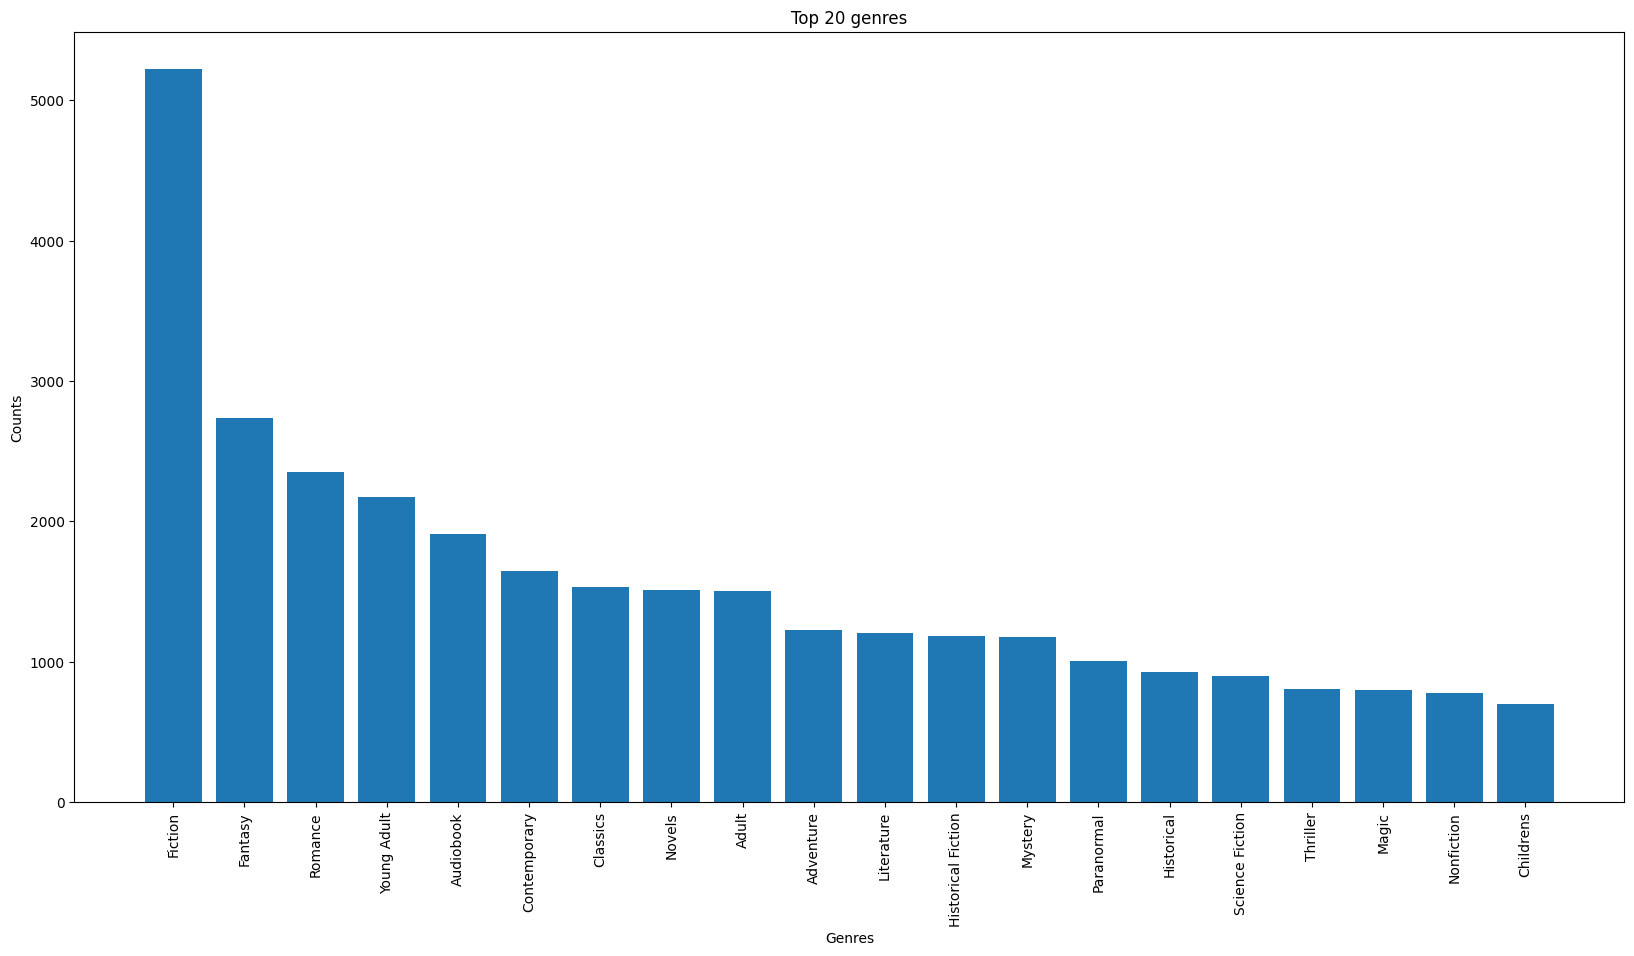

In [23]:
# Visualize top 20 genres
plt.figure(figsize=(20, 10))
plt.bar(range(len(top_20_genres)), [val[1] for val in top_20_genres], align='center')
plt.xticks(range(len(top_20_genres)), [val[0] for val in top_20_genres])
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Counts')
plt.title('Top 20 genres')
plt.show()

In [24]:
top_20_genres_col = [genre[0] for genre in top_20_genres]

# Tạo cột cho mỗi thể loại
for genre in top_20_genres_col:
    X_train[genre] = X_train['genres'].apply(lambda x: 1 if genre in x else 0)
    X_val[genre] = X_val['genres'].apply(lambda x: 1 if genre in x else 0)
    X_test[genre] = X_test['genres'].apply(lambda x: 1 if genre in x else 0)

pd.set_option('display.max_columns', None)

X_train.head()

,title,author,language,ratings_count,reviews_count,publisher,publish_year,num_pages,page_format,genres,Fiction,Fantasy,Romance,Young Adult,Audiobook,Contemporary,Classics,Novels,Adult,Adventure,Literature,Historical Fiction,Mystery,Paranormal,Historical,Science Fiction,Thriller,Magic,Nonfiction,Childrens
7003,Until Friday Night,Abbi Glines,English,60584,5405,Simon Pulse,2015.0,336.0,ebook,"Contemporary,Contemporary Romance,Fiction,High...",1,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4062,Bad Science,Ben Goldacre,English,42034,2156,HarperCollins Publishers,2008.0,338.0,Paperback,"Audiobook,Health,Humor,Medical,Medicine,Nonfic...",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4239,Cut,Patricia McCormick,English,57237,2960,Push,2002.0,151.0,Paperback,"Contemporary,Drama,Fiction,Mental Health,Menta...",1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0
9463,Night Whispers,Erin Hunter,English,12988,360,HarperCollins,2010.0,352.0,Hardcover,"Action,Adventure,Animal Fiction,Animals,Cats,C...",1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1
4142,The Hazel Wood,Melissa Albert,English,87888,13586,Flatiron Books,2018.0,359.0,Hardcover,"Audiobook,Fairy Tales,Fantasy,Fiction,Magic,Ma...",1,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0


In [25]:
def addNewFeatures(data):
    data['title_count'] = data.groupby('title')['title'].transform('count')
    data.loc[data['reviews_count'] == 0, 'reviews_count'] = 1
    data['title_length'] = data['title'].apply(lambda x: len(x))
    data['publisher_count'] = data.groupby('publisher')['publisher'].transform('count')
    data['rating_review_ratio'] = data['ratings_count'] / data['reviews_count']
    data['books_by_author'] = data.groupby('author')['author'].transform('count')
    data['is_famous_author'] = data['books_by_author'].apply(lambda x: 1 if x > 10 else 0)

    drops = ['title', 'genres', 'author', 'publisher', 'language']
    for col in drops:
        data.drop([col], axis=1, inplace=True)

In [26]:
addNewFeatures(X_train)
addNewFeatures(X_val)
addNewFeatures(X_test)

X_train.head()

,ratings_count,reviews_count,publish_year,num_pages,page_format,Fiction,Fantasy,Romance,Young Adult,Audiobook,Contemporary,Classics,Novels,Adult,Adventure,Literature,Historical Fiction,Mystery,Paranormal,Historical,Science Fiction,Thriller,Magic,Nonfiction,Childrens,title_count,title_length,publisher_count,rating_review_ratio,books_by_author,is_famous_author
7003,60584,5405,2015.0,336.0,ebook,1,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,18,46.0,11.208881,12,1
4062,42034,2156,2008.0,338.0,Paperback,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,11,31.0,19.496289,1,0
4239,57237,2960,2002.0,151.0,Paperback,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,3,1.0,19.336824,1,0
9463,12988,360,2010.0,352.0,Hardcover,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,14,91.0,36.077778,24,1
4142,87888,13586,2018.0,359.0,Hardcover,1,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,14,12.0,6.469012,1,0


In [27]:
cols = ['page_format']
for col in cols:
    X_train, X_val, X_test = string_to_num(X_train, X_val, X_test, col)

X_train.head()

,ratings_count,reviews_count,publish_year,num_pages,page_format,Fiction,Fantasy,Romance,Young Adult,Audiobook,Contemporary,Classics,Novels,Adult,Adventure,Literature,Historical Fiction,Mystery,Paranormal,Historical,Science Fiction,Thriller,Magic,Nonfiction,Childrens,title_count,title_length,publisher_count,rating_review_ratio,books_by_author,is_famous_author
7003,60584,5405,2015.0,336.0,24,1,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,18,46.0,11.208881,12,1
4062,42034,2156,2008.0,338.0,15,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,11,31.0,19.496289,1,0
4239,57237,2960,2002.0,151.0,15,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,3,1.0,19.336824,1,0
9463,12988,360,2010.0,352.0,8,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,14,91.0,36.077778,24,1
4142,87888,13586,2018.0,359.0,8,1,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,14,12.0,6.469012,1,0


In [28]:
X_train.isnull().sum()

ratings_count            0
reviews_count            0
publish_year            42
num_pages               80
page_format              0
Fiction                  0
Fantasy                  0
Romance                  0
Young Adult              0
Audiobook                0
Contemporary             0
Classics                 0
Novels                   0
Adult                    0
Adventure                0
Literature               0
Historical Fiction       0
Mystery                  0
Paranormal               0
Historical               0
Science Fiction          0
Thriller                 0
Magic                    0
Nonfiction               0
Childrens                0
title_count              0
title_length             0
publisher_count        231
rating_review_ratio      0
books_by_author          0
is_famous_author         0
dtype: int64

In [29]:
X_train, X_val, X_test = fillMissingData(X_train, X_val, X_test)
result = trainModel(X_train, y_train, X_val, y_val)
result

,MAE,RMSE,r2score
Random Forest,0.164687,0.211964,0.579073
SVR,0.209580,0.327434,-0.004454


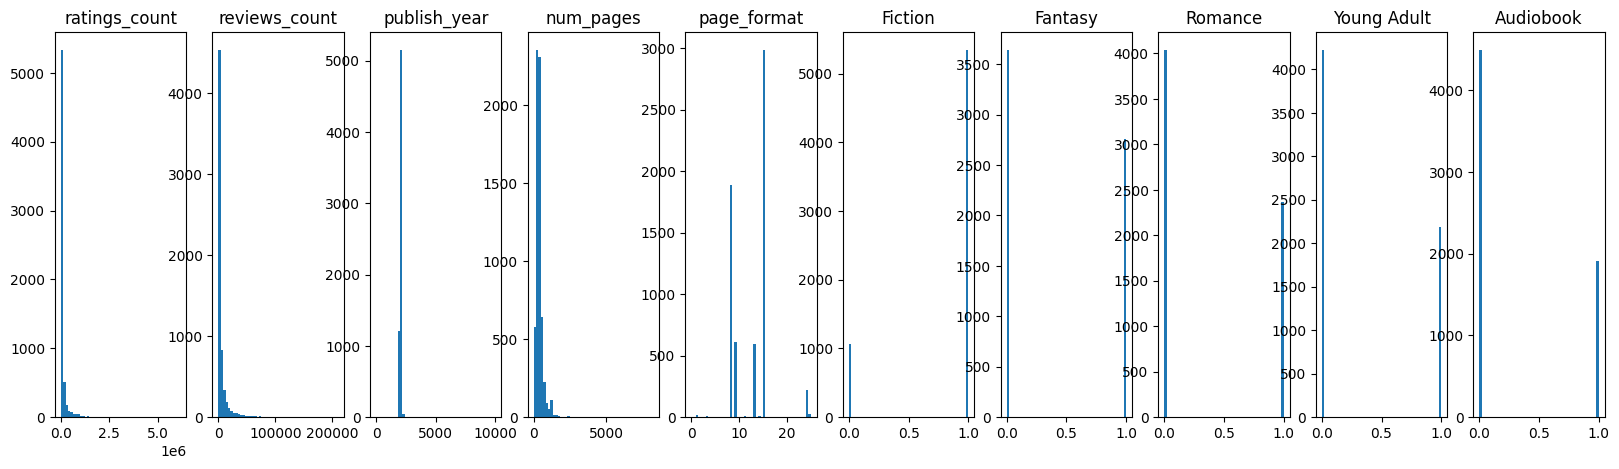

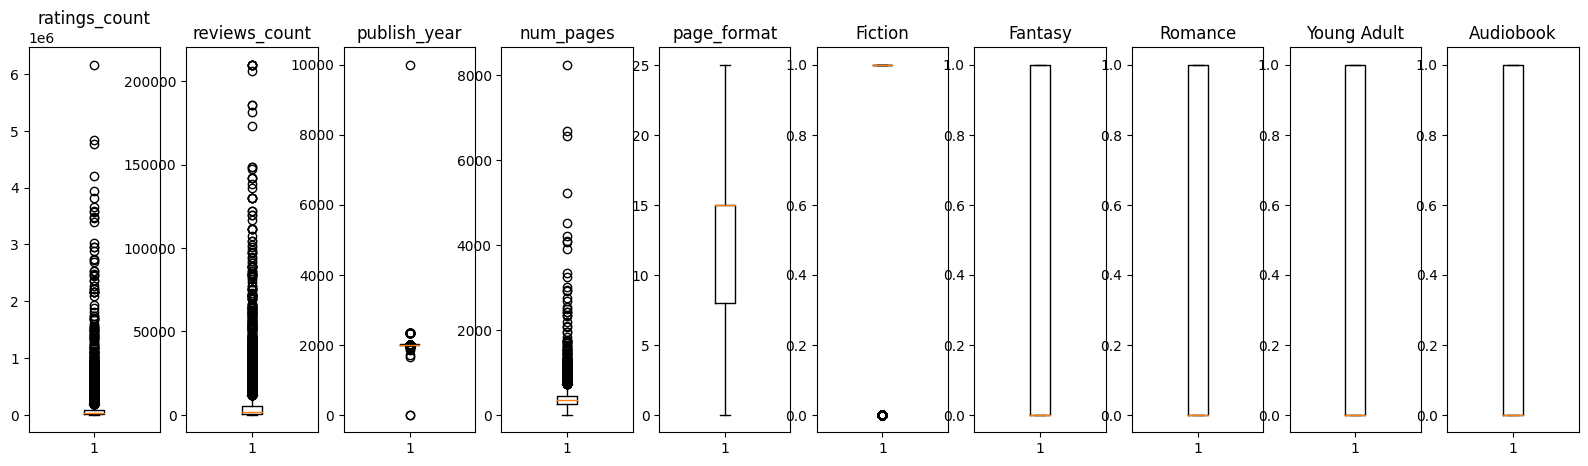

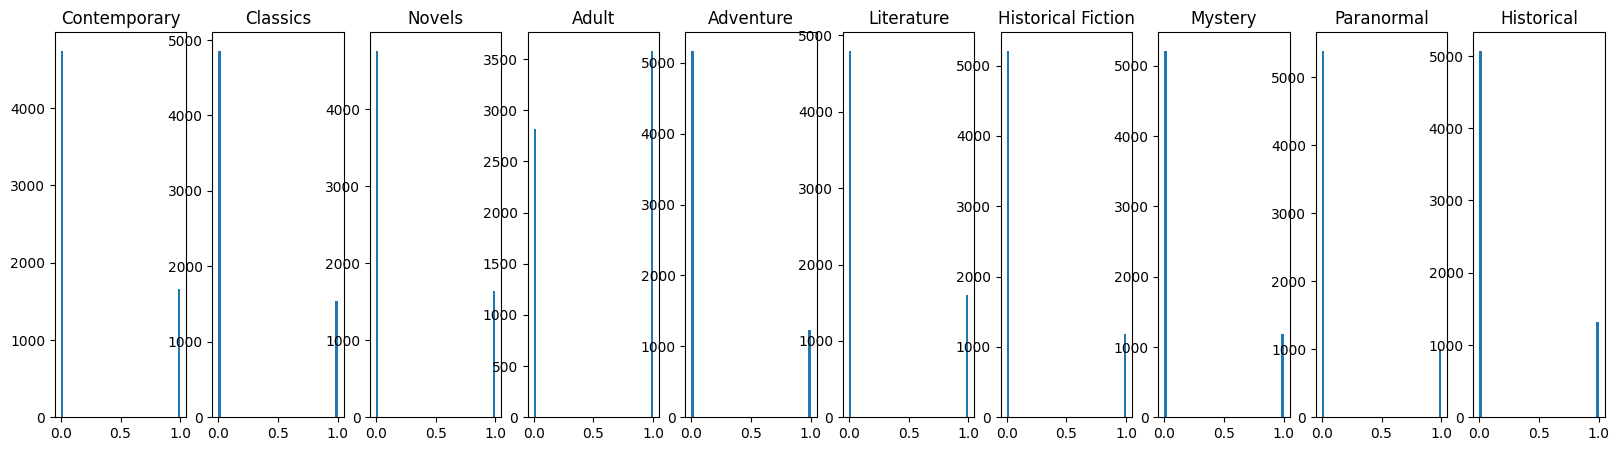

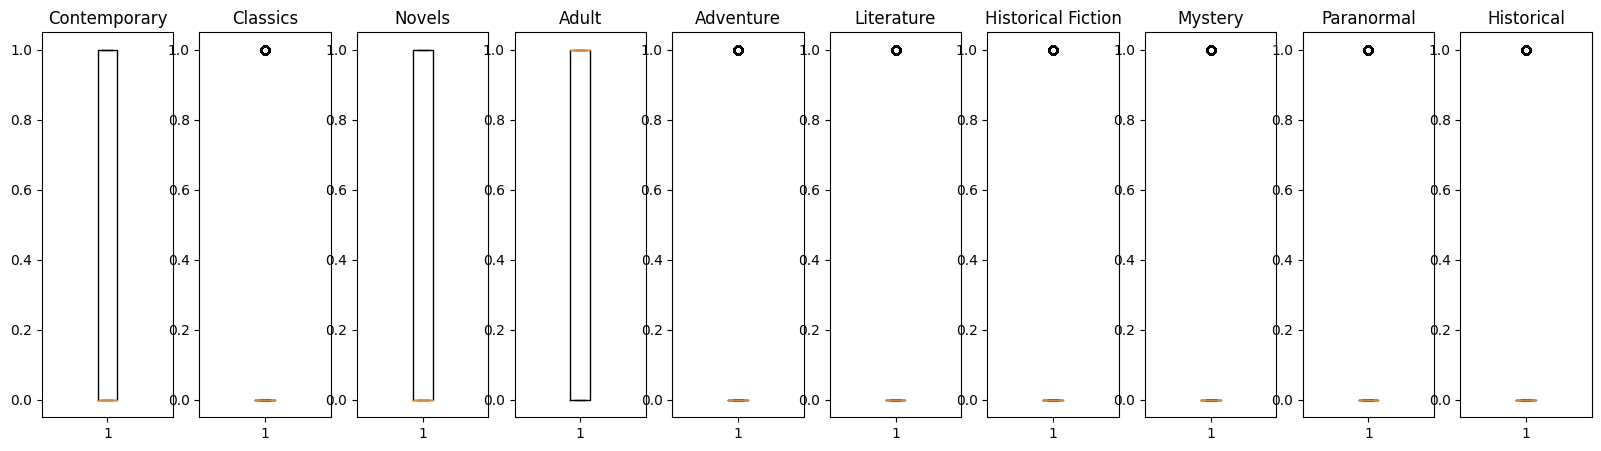

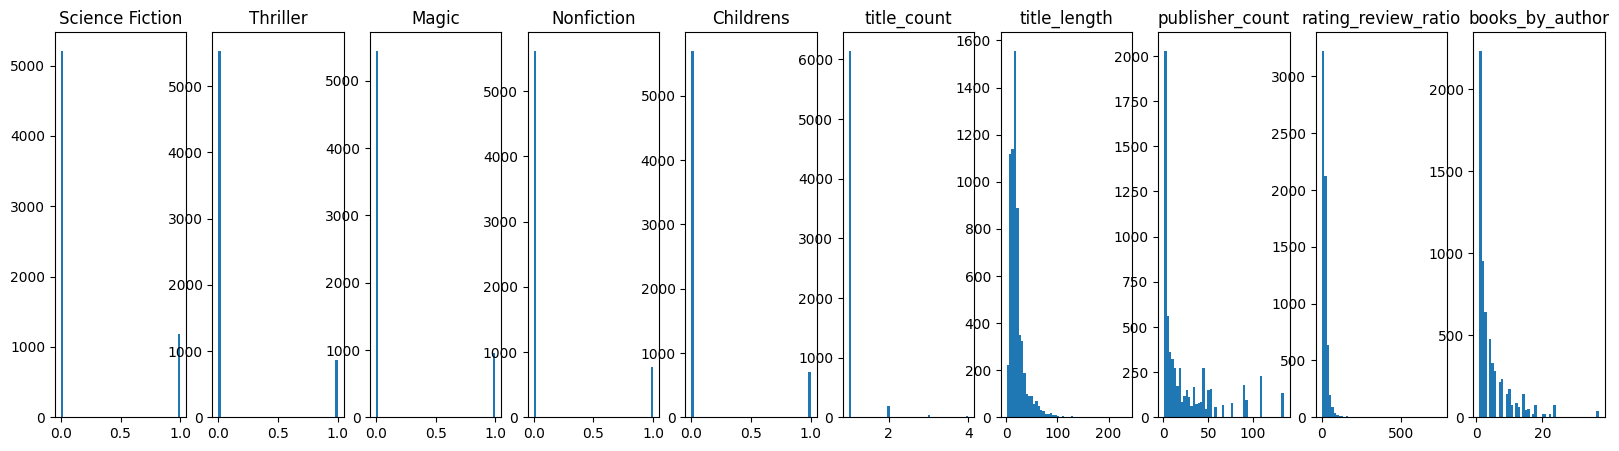

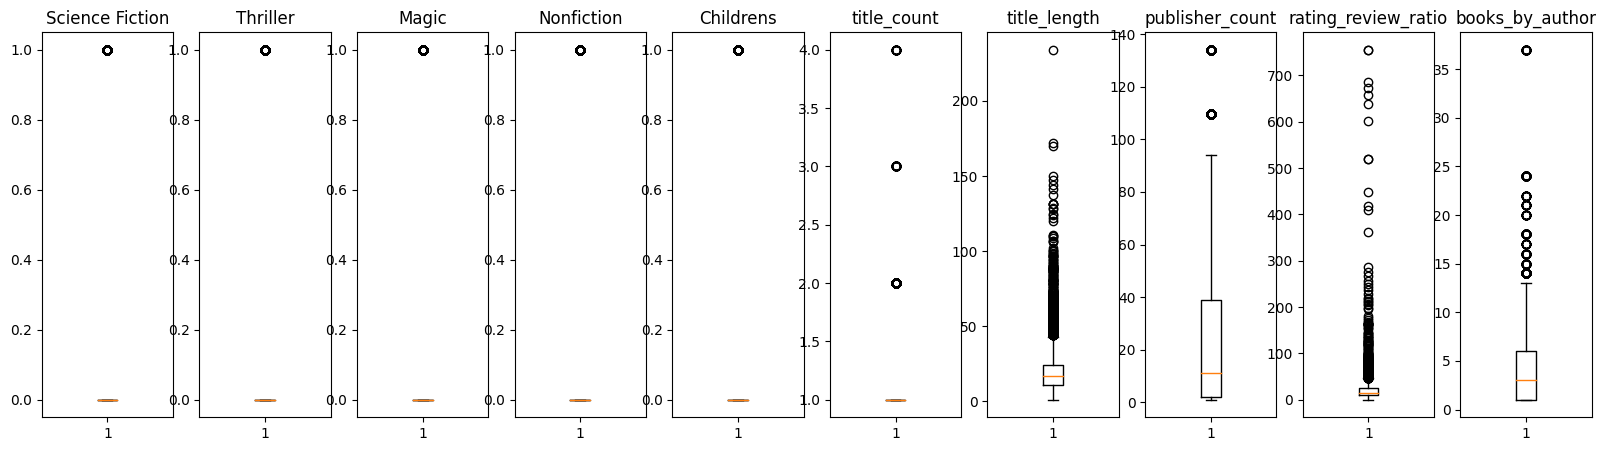

In [30]:
cols = X_train.columns
for i in range(0, 3):
    plotDistribution(X_train, cols[i*10: (i+1)*10])
    plotBox(X_train, cols[i*10: (i+1)*10])

In [31]:
X_train, X_val, X_test = handleOutlier(X_train, X_val, X_test)
result = trainModel(X_train, y_train, X_val, y_val)
result

,MAE,RMSE,r2score
Random Forest,0.171121,0.218815,0.551422
SVR,0.206867,0.327528,-0.005031


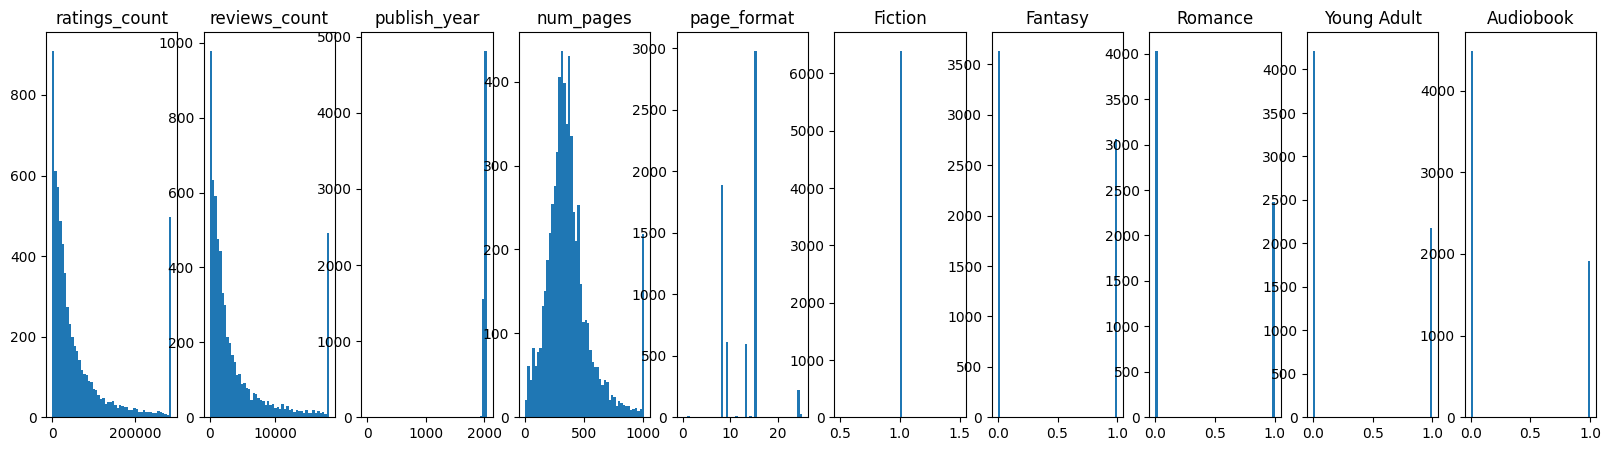

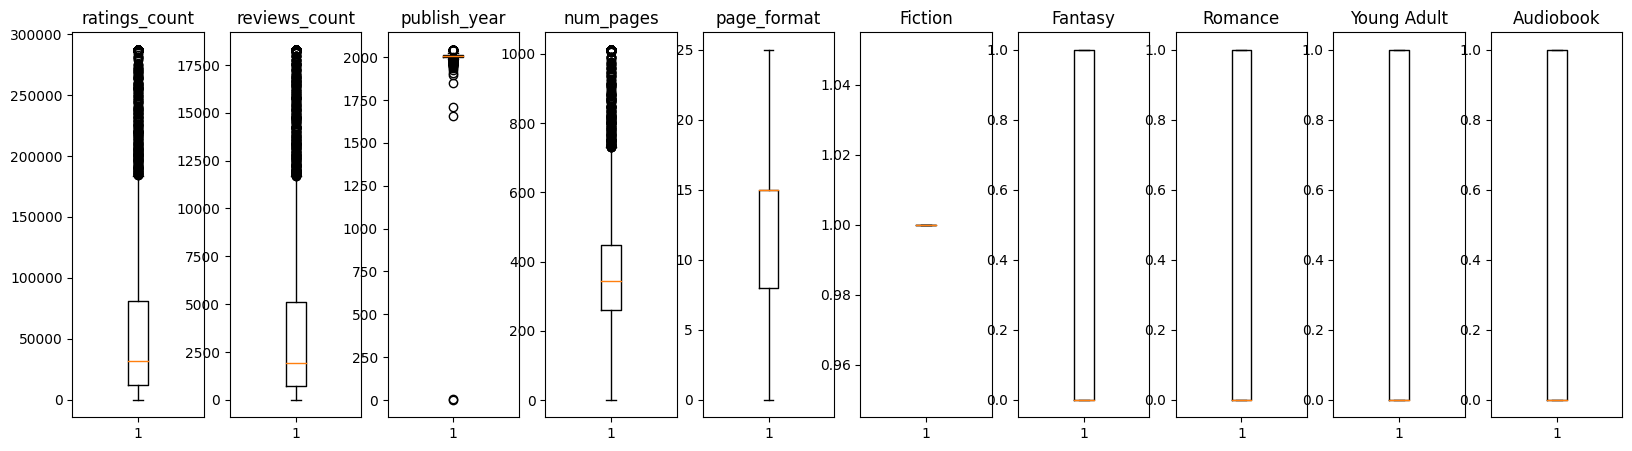

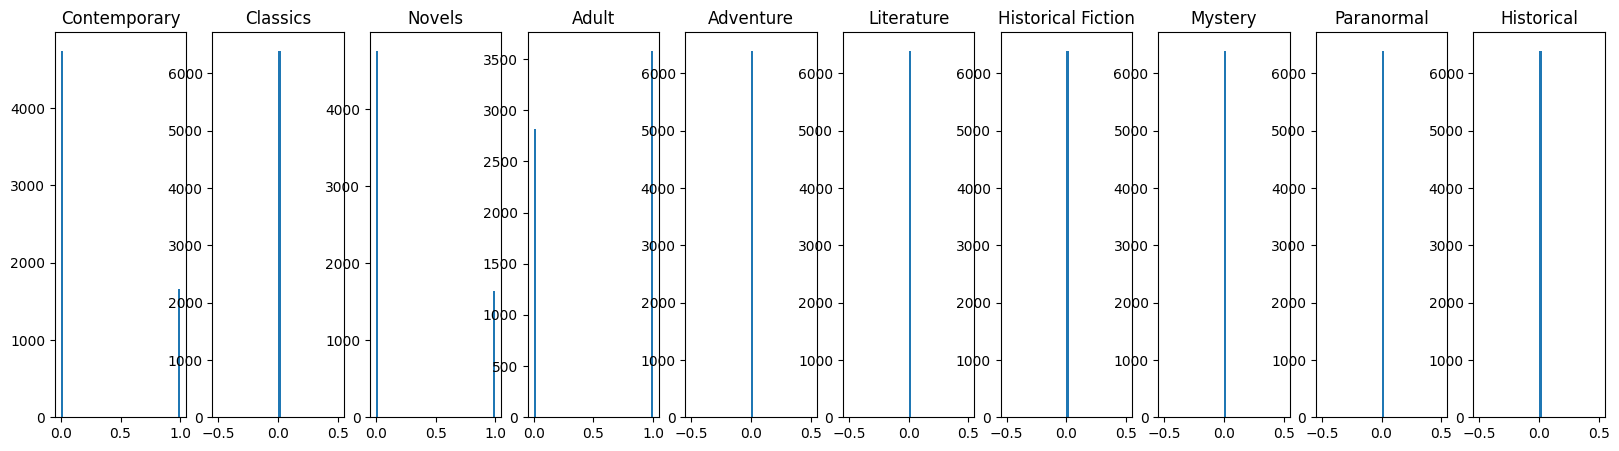

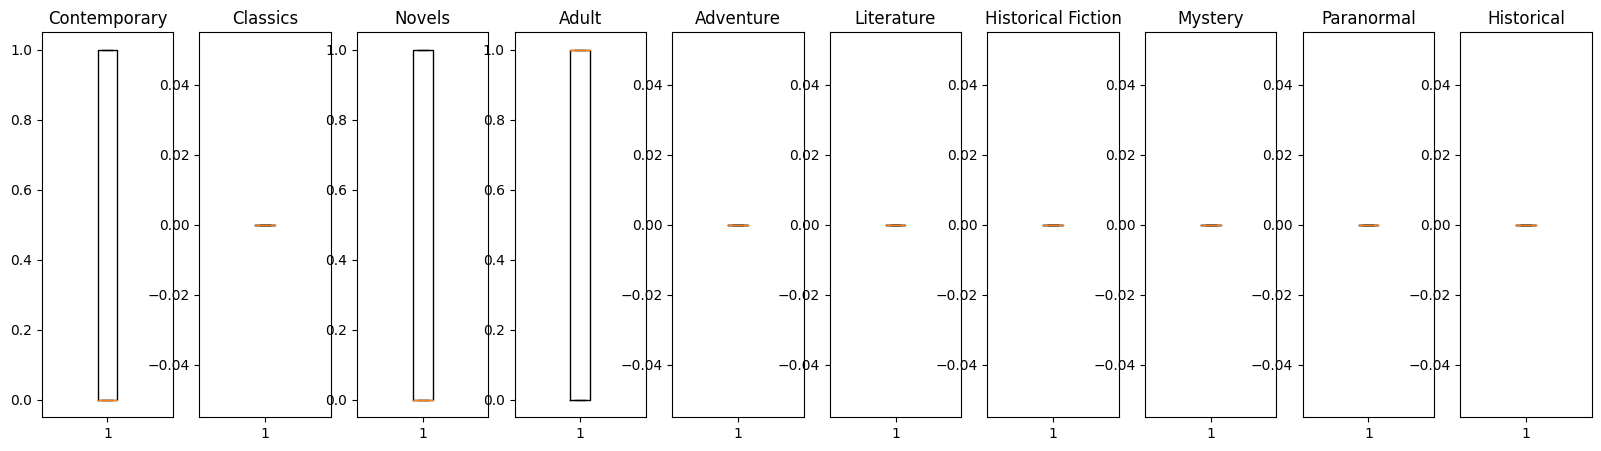

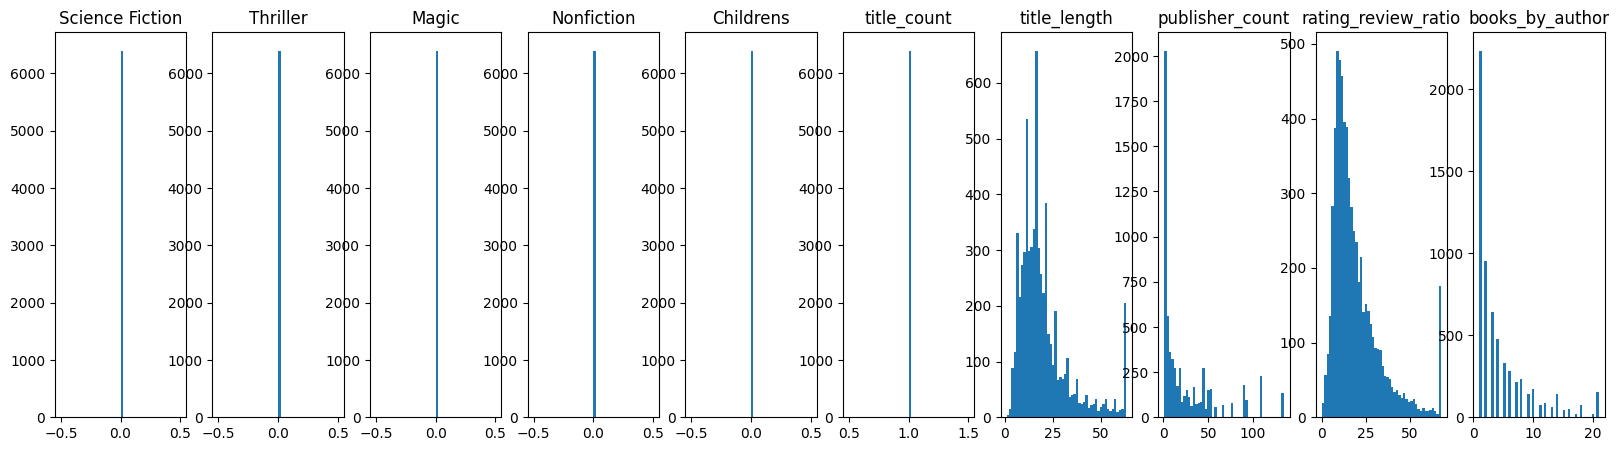

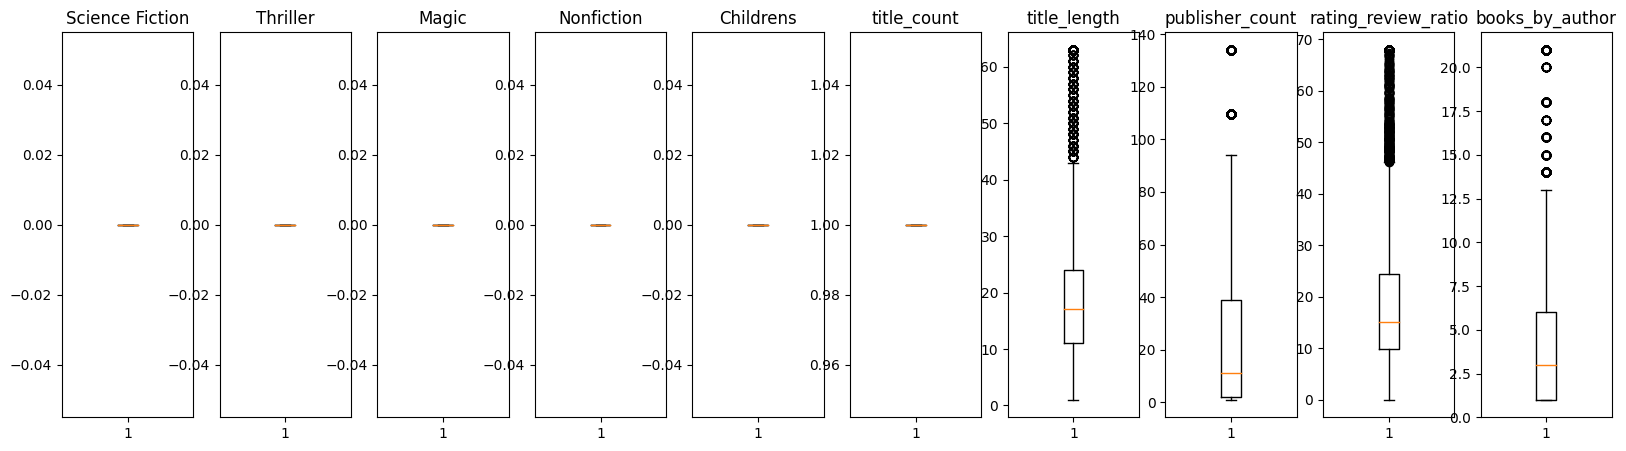

In [32]:
cols = X_train.columns
for i in range(0, 3):
    plotDistribution(X_train, cols[i*10: (i+1)*10])
    plotBox(X_train, cols[i*10: (i+1)*10])

In [33]:
# for scaler in scalerArr:
#     print(f'{scaler}:')
#     X_train1, X_val1, X_test1 = scaleData(X_train.copy(), X_val.copy(), X_test.copy(), scaler)
#     result = trainModel(X_train1, y_train, X_val1, y_val)
#     print(result)
#     print()

In [34]:
X_train, X_val, X_test = scaleData(X_train, X_val, X_test, powerTransformer)
result = trainModel(X_train, y_train, X_val, y_val)
result

,MAE,RMSE,r2score
Random Forest,0.170382,0.218603,0.552290
SVR,0.182247,0.280988,0.260298


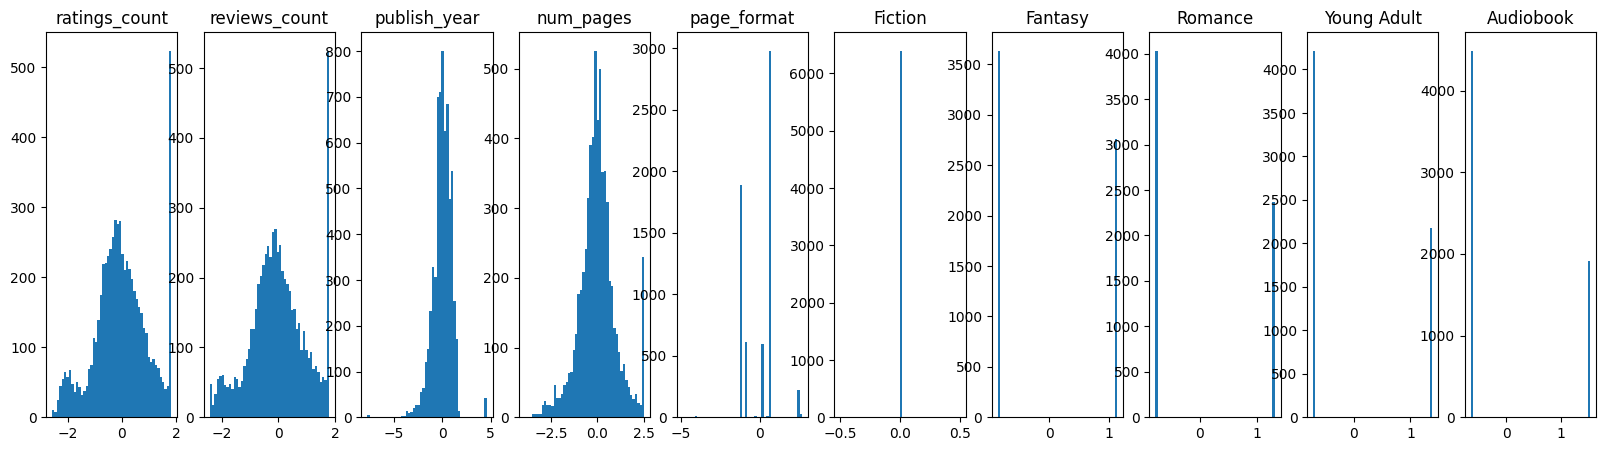

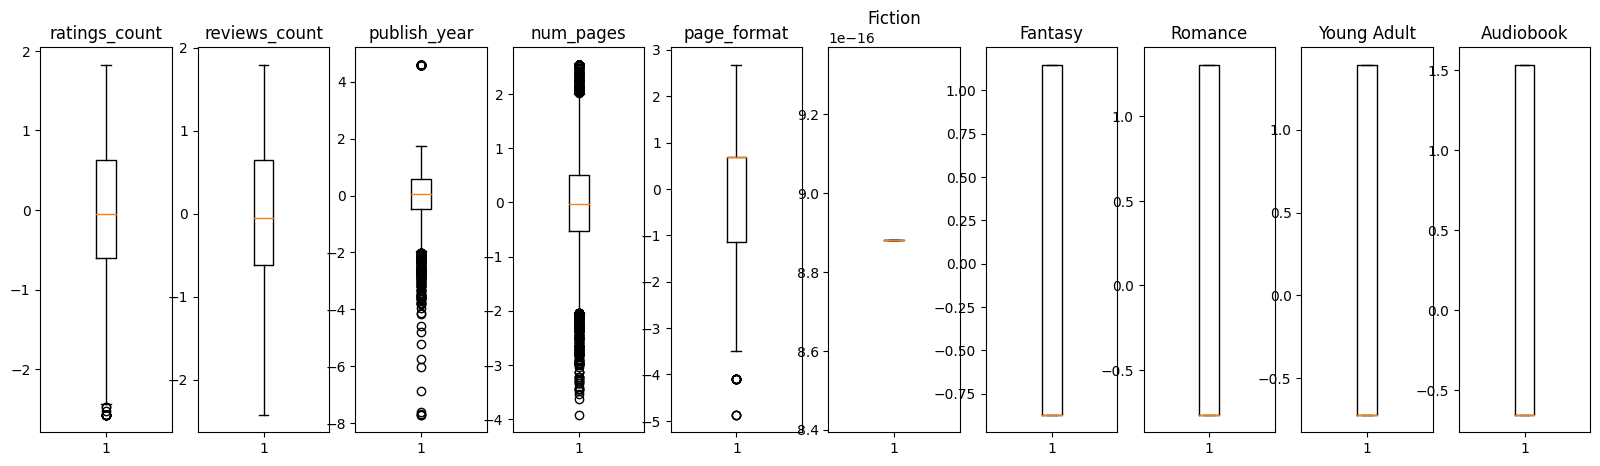

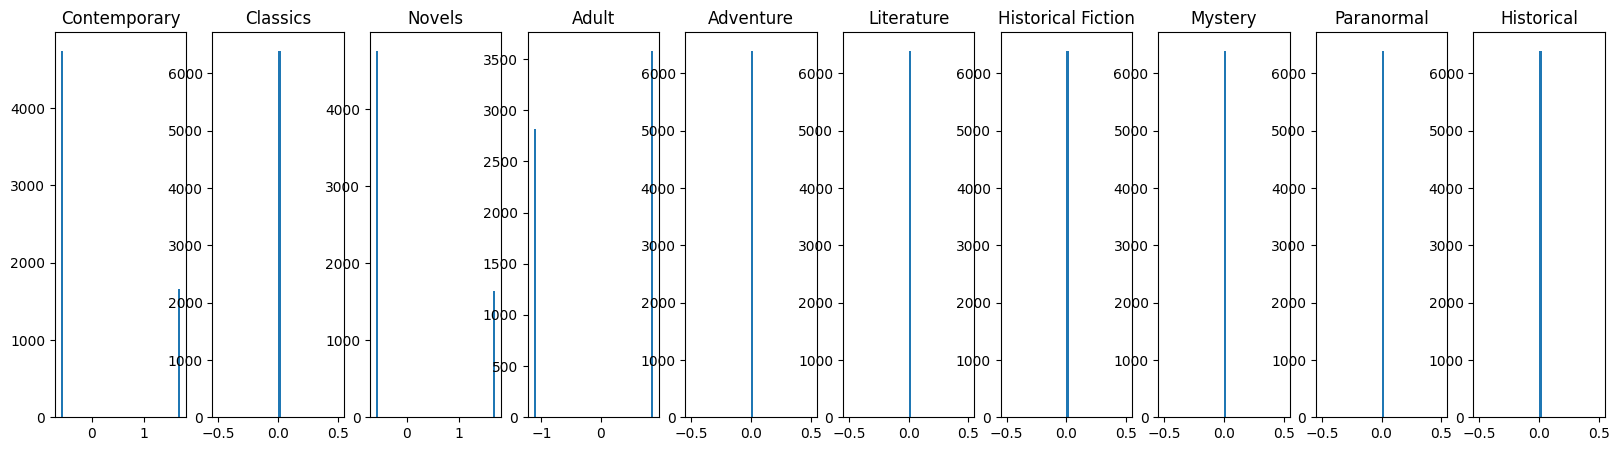

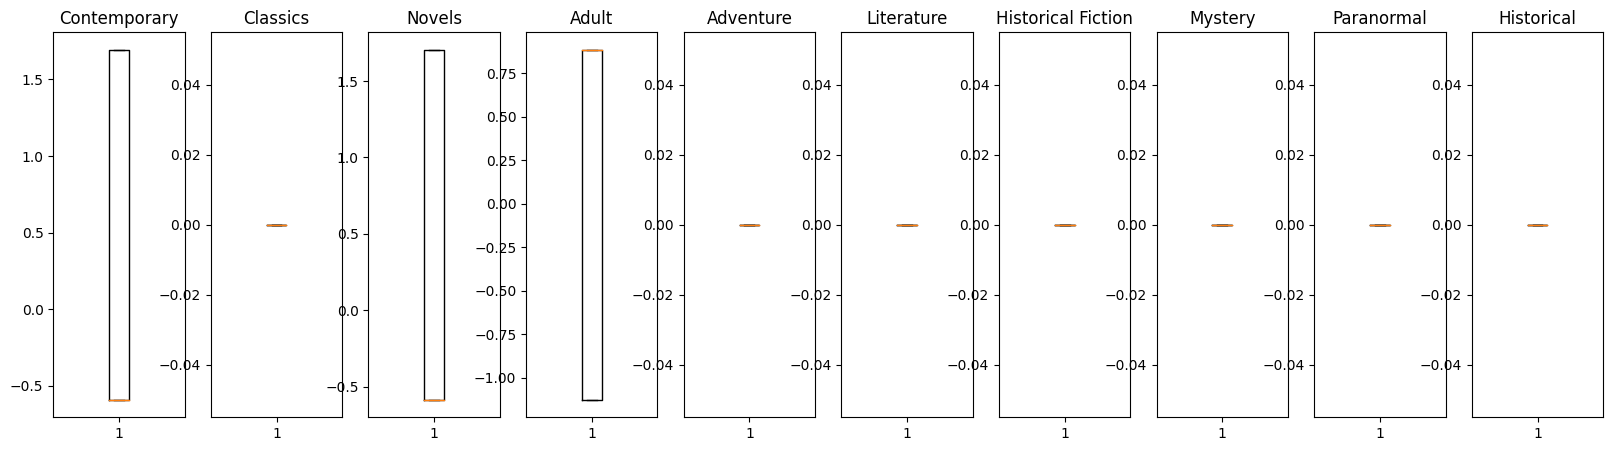

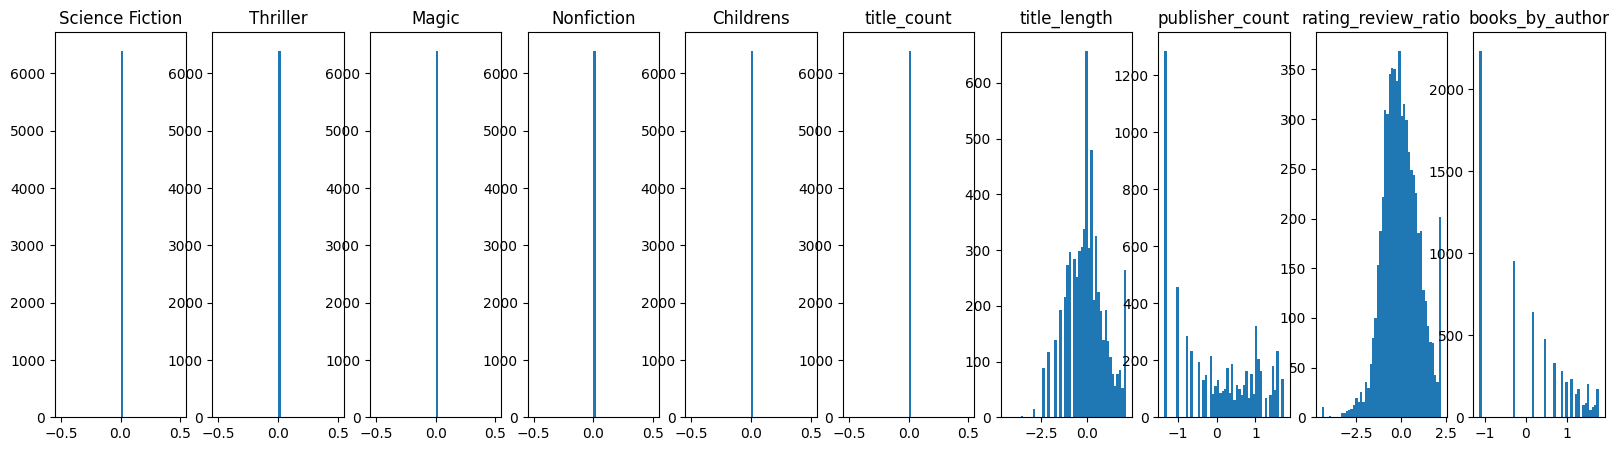

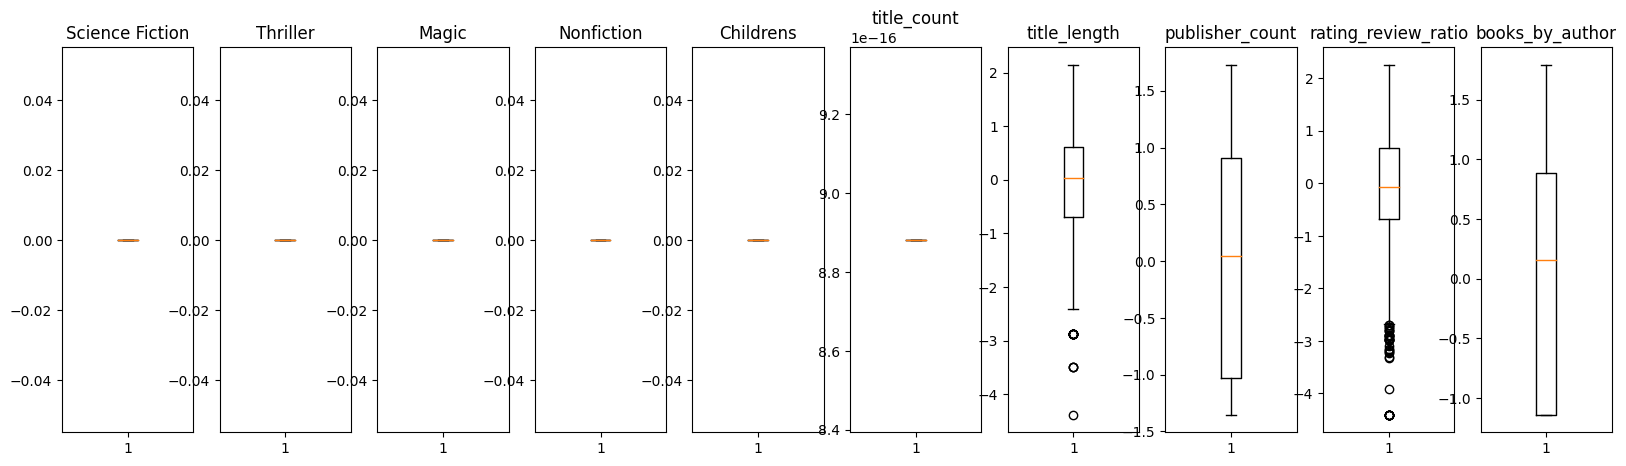

In [35]:
cols = X_train.columns
for i in range(0, 3):
    plotDistribution(X_train, cols[i*10: (i+1)*10])
    plotBox(X_train, cols[i*10: (i+1)*10])

In [36]:
X_train_SF, X_val_SF, X_test_SF = selectFeatures(X_train, y_train, X_val, X_test)
result = trainModel(X_train_SF, y_train, X_val_SF, y_val)
result

['ratings_count' 'reviews_count' 'publish_year' 'num_pages' 'page_format'
 'Fantasy' 'Romance' 'Young Adult' 'Audiobook' 'Contemporary' 'Novels'
 'title_length' 'publisher_count' 'rating_review_ratio' 'books_by_author'
 'is_famous_author']


,MAE,RMSE,r2score
Random Forest,0.171052,0.218873,0.551186
SVR,0.182018,0.278148,0.275174


In [44]:
y_train.head()

7003    3.89
4062    4.06
4239    3.76
9463    4.36
4142    3.57
Name: avg_ratings, dtype: float64

In [37]:
data_train = pd.concat([X_train, y_train], axis=1)

data_train.head()

,ratings_count,reviews_count,publish_year,num_pages,page_format,Fiction,Fantasy,Romance,Young Adult,Audiobook,Contemporary,Classics,Novels,Adult,Adventure,Literature,Historical Fiction,Mystery,Paranormal,Historical,Science Fiction,Thriller,Magic,Nonfiction,Childrens,title_count,title_length,publisher_count,rating_review_ratio,books_by_author,is_famous_author,avg_ratings
0,0.403950,0.693417,0.798047,-0.071480,2.496649,8.881784e-16,-0.871288,1.305866,1.390510,-0.652121,1.692885,0.0,-0.586856,0.886372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.881784e-16,0.131268,1.020259,-0.501764,1.447743,2.808222,NaN
1,0.138715,0.027903,0.041830,-0.060487,0.678419,8.881784e-16,-0.871288,-0.765775,-0.719161,1.533458,-0.590707,0.0,-0.586856,-1.128195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.881784e-16,-0.702843,0.752008,0.318326,-1.139139,-0.356097,NaN
2,0.361205,0.243440,-0.554457,-1.323114,0.678419,8.881784e-16,-0.871288,-0.765775,1.390510,-0.652121,1.692885,0.0,1.703995,0.886372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.881784e-16,-2.874610,-1.353931,0.305933,-1.139139,-0.356097,4.28
3,-0.574367,-0.958690,0.251018,0.015445,-1.151717,8.881784e-16,1.147727,-0.765775,1.390510,-0.652121,-0.590707,0.0,-0.586856,0.886372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.881784e-16,-0.292594,1.475993,1.261549,1.791037,2.808222,NaN
4,0.698340,1.498758,1.143452,0.052767,-1.151717,8.881784e-16,1.147727,-0.765775,1.390510,1.533458,-0.590707,0.0,-0.586856,0.886372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.881784e-16,-0.292594,0.101532,-1.275952,-1.139139,-0.356097,4.39


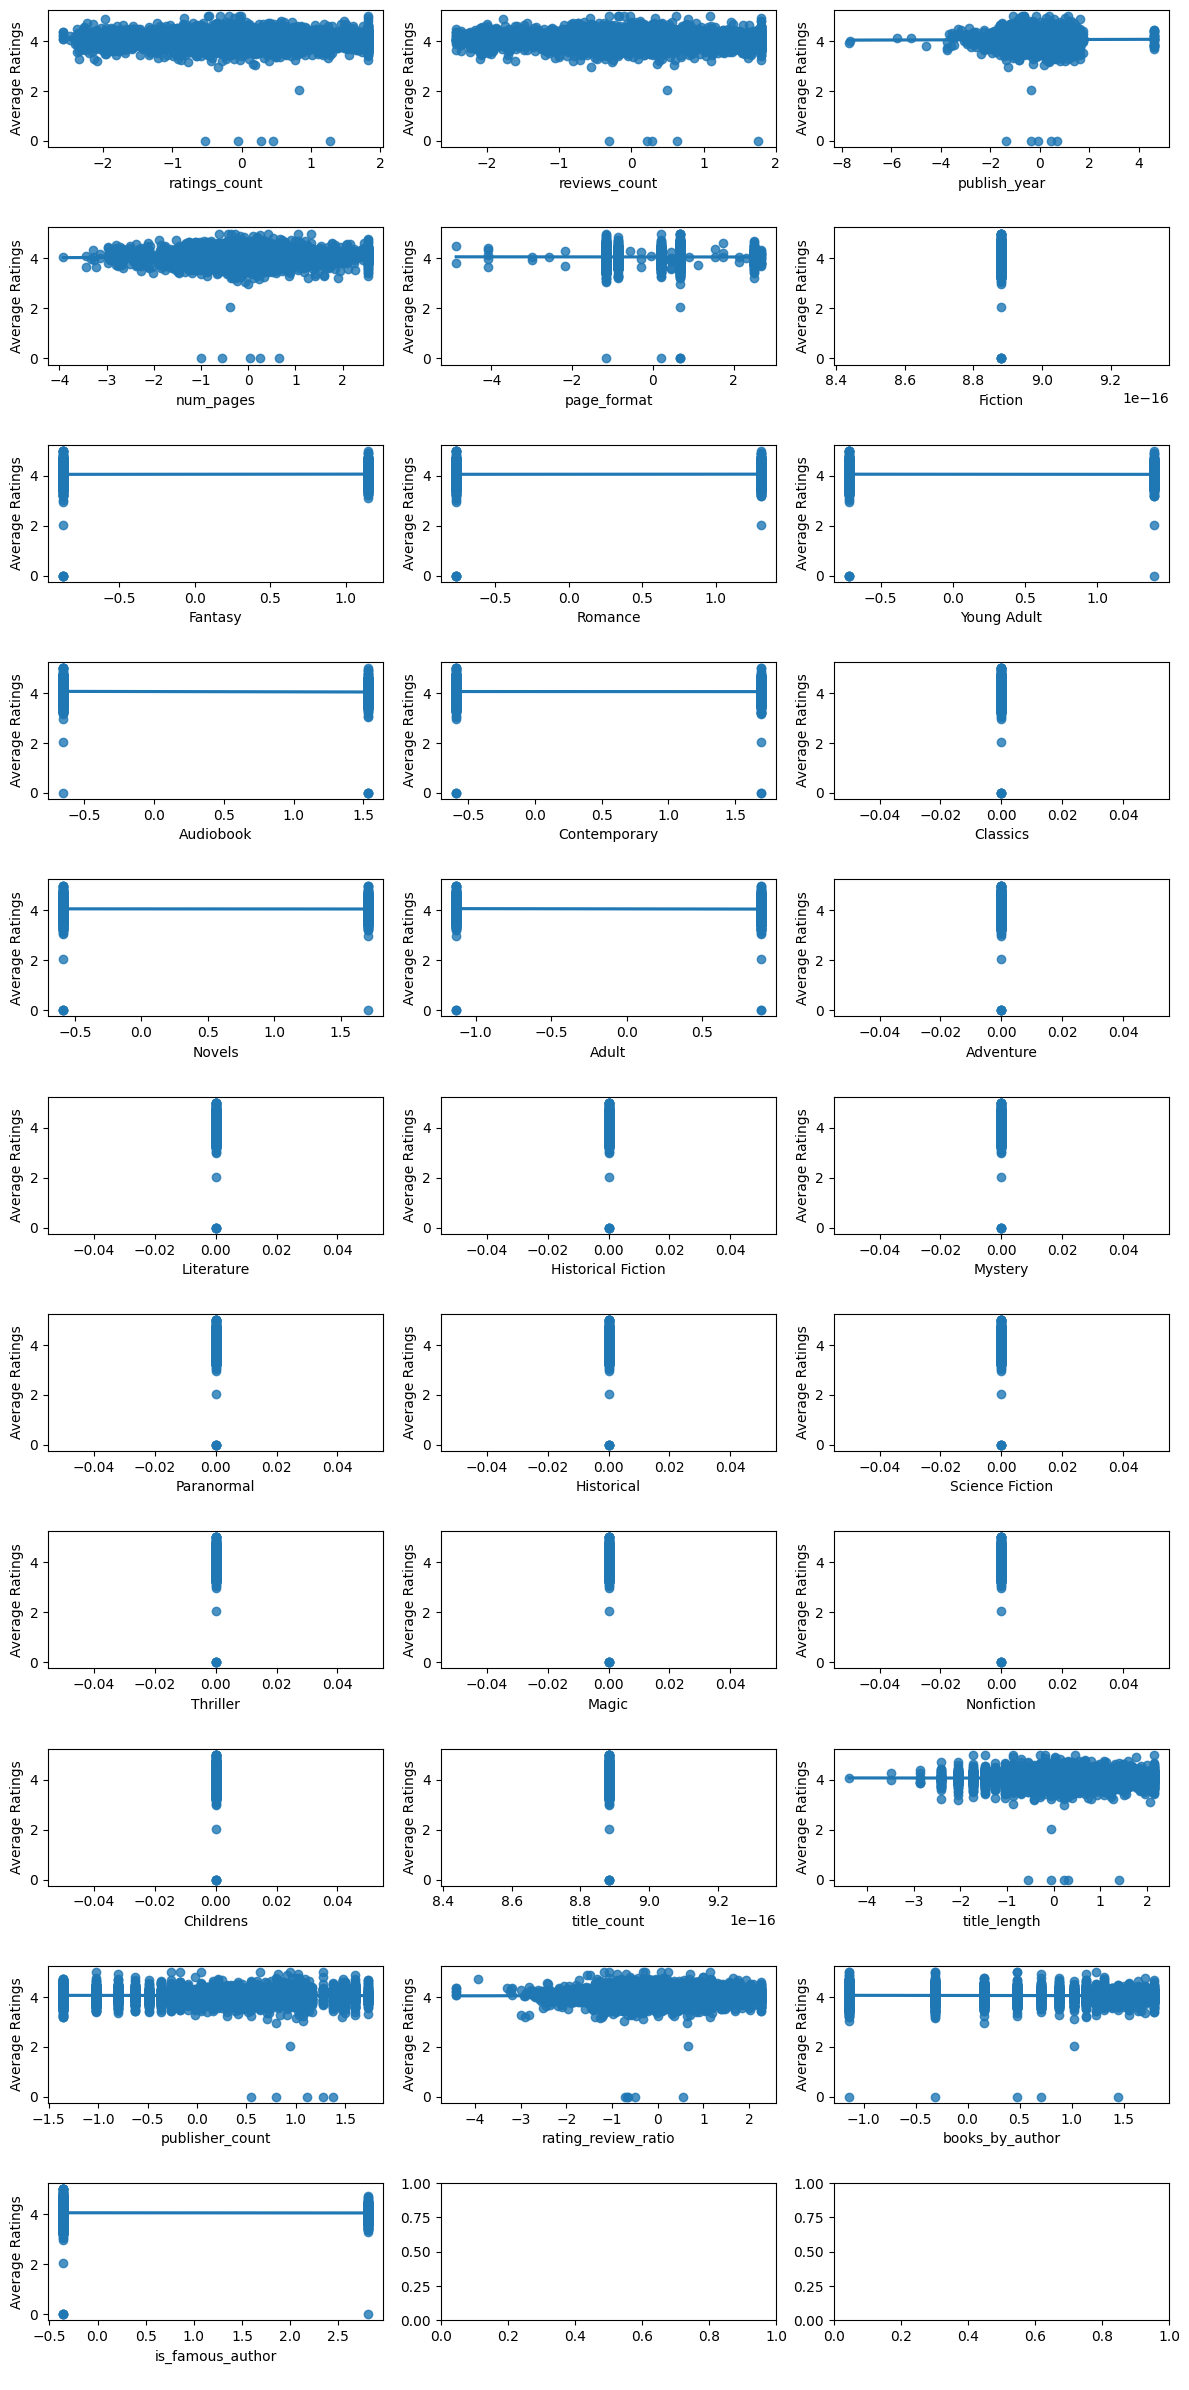

In [38]:
cols = data_train.columns.tolist()
cols.remove('avg_ratings')
# cols.remove('page_format')
cols_len = len(cols)
num_rows = cols_len // 3 + 1
fig, ax = plt.subplots(num_rows, 3, figsize=(12, 24))
for i in range(cols_len):
    sns.regplot(x=cols[i], y='avg_ratings', data=data_train, ax=ax[i // 3][i % 3])
    ax[i // 3][i % 3].set_xlabel(cols[i] + '\n')
    ax[i // 3][i % 3].set_ylabel('Average Ratings')

plt.tight_layout()
plt.show()

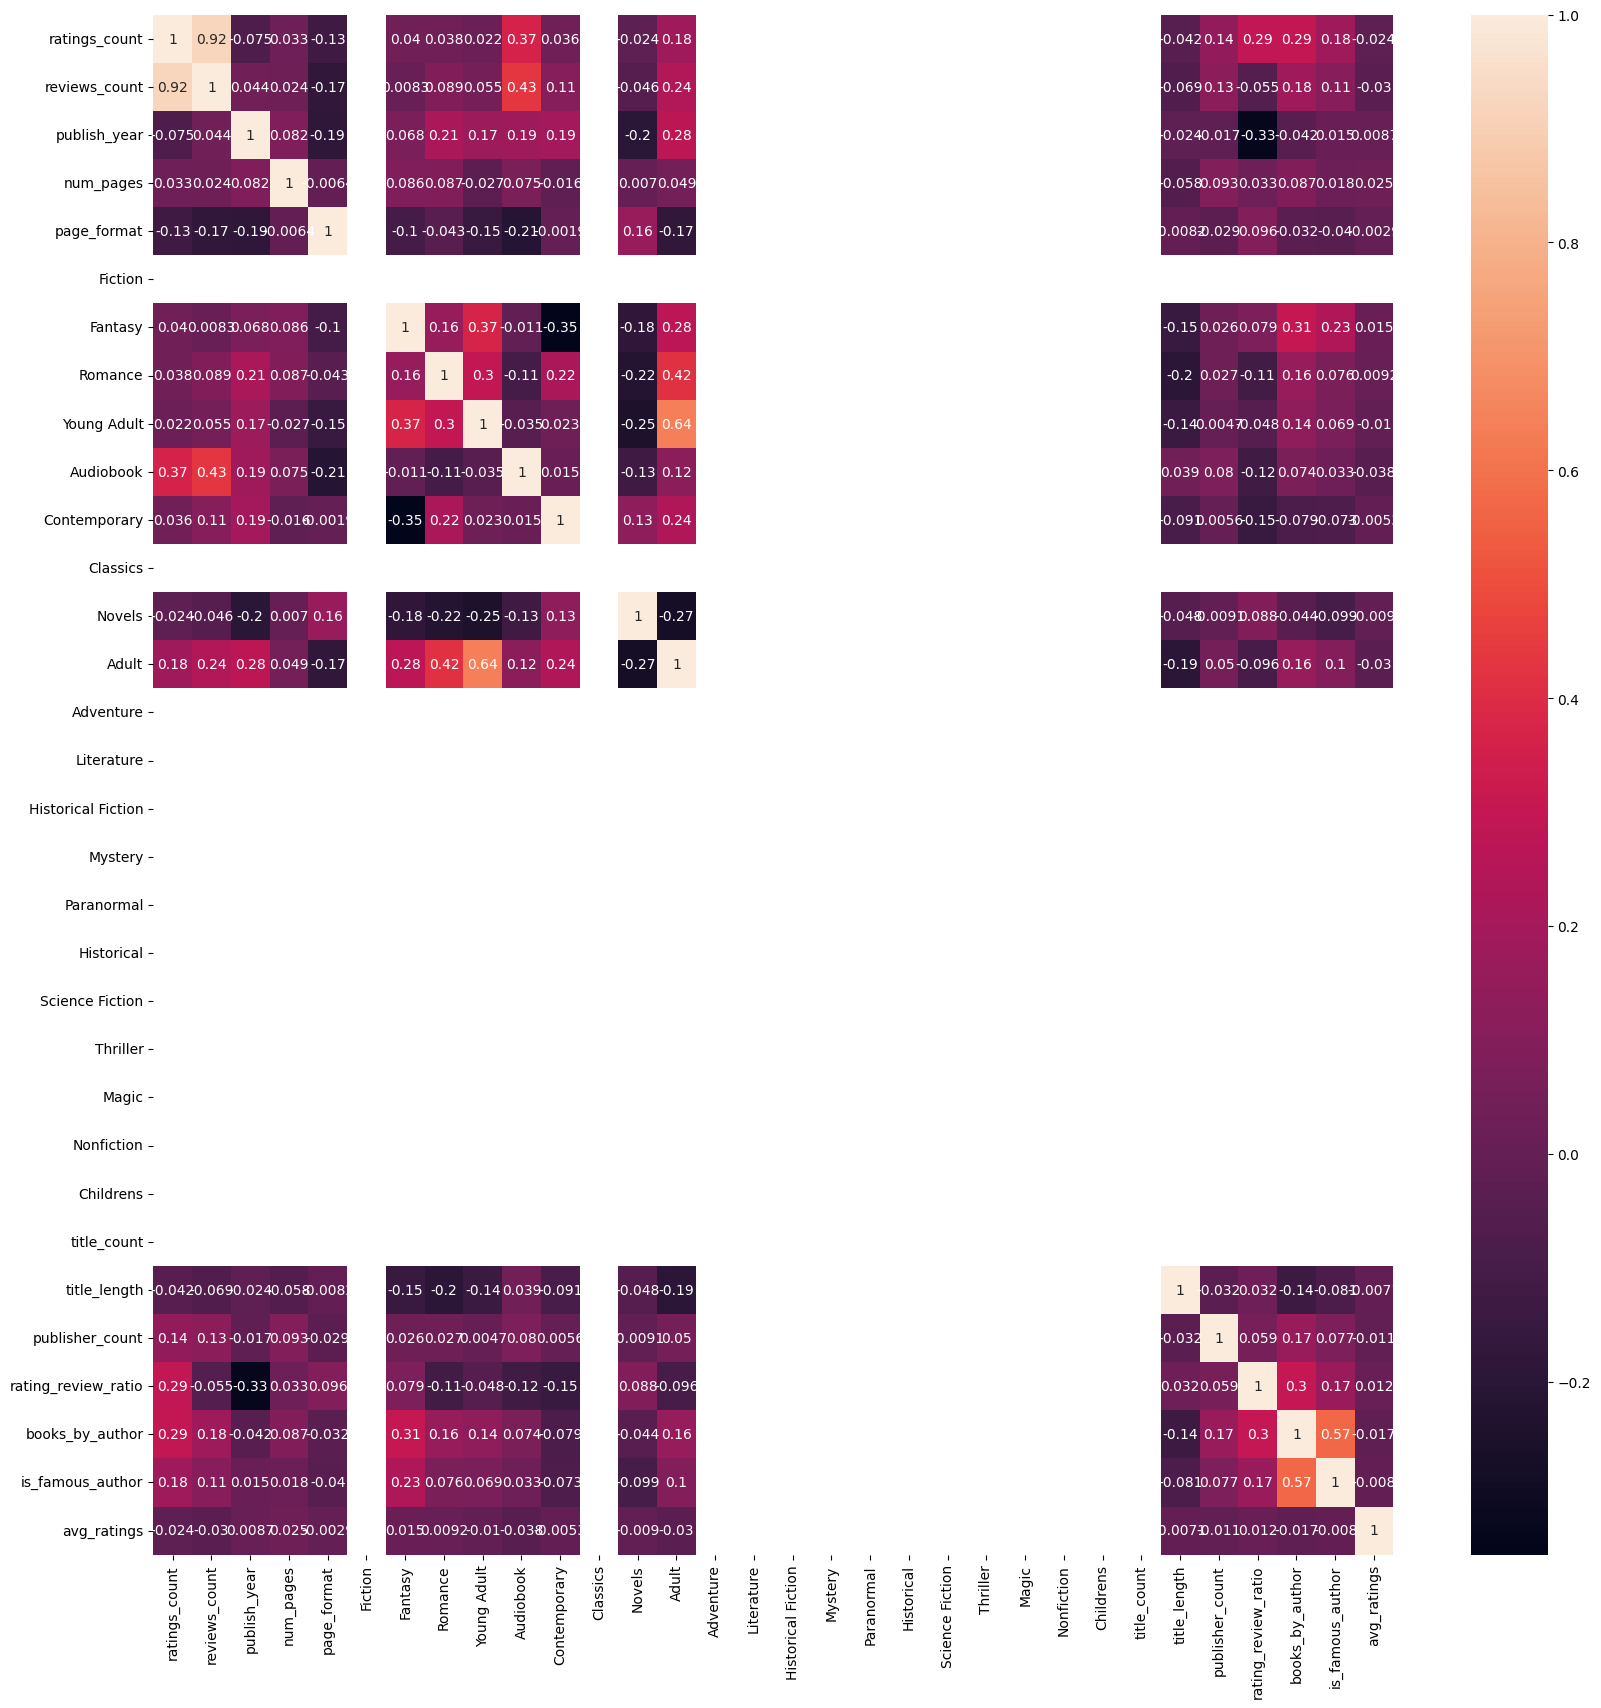

In [39]:
def plot_heatmap(data):
    # get correlation matrix
    corr = data.corr()
    plt.figure(figsize=(20, 20))

    # plot heatmap
    sns.heatmap(corr, annot=True)
    plt.show()

plot_heatmap(data_train)

In [40]:
corr = data_train.corr()
corr['avg_ratings'].sort_values(ascending=False)

avg_ratings            1.000000
num_pages              0.024699
Fantasy                0.015087
rating_review_ratio    0.011644
Romance                0.009171
publish_year           0.008736
page_format           -0.002938
Contemporary          -0.005336
title_length          -0.007121
is_famous_author      -0.007971
Novels                -0.008958
Young Adult           -0.010250
publisher_count       -0.010606
books_by_author       -0.017280
ratings_count         -0.023731
Adult                 -0.029706
reviews_count         -0.030000
Audiobook             -0.038451
Fiction                     NaN
Classics                    NaN
Adventure                   NaN
Literature                  NaN
Historical Fiction          NaN
Mystery                     NaN
Paranormal                  NaN
Historical                  NaN
Science Fiction             NaN
Thriller                    NaN
Magic                       NaN
Nonfiction                  NaN
Childrens                   NaN
title_co

In [41]:
top_16_corr = corr['avg_ratings'].sort_values(ascending=False)[:17]
top_16_corr.index

Index(['avg_ratings', 'num_pages', 'Fantasy', 'rating_review_ratio', 'Romance',
       'publish_year', 'page_format', 'Contemporary', 'title_length',
       'is_famous_author', 'Novels', 'Young Adult', 'publisher_count',
       'books_by_author', 'ratings_count', 'Adult', 'reviews_count'],
      dtype='object')

In [42]:
features = top_16_corr.index.tolist()
features.remove('avg_ratings')
X_train1 = X_train[features]
X_val1 = X_val[features]
X_test1 = X_test[features]
result = trainModel(X_train1, y_train, X_val1, y_val)
result

,MAE,RMSE,r2score
Random Forest,0.170913,0.218635,0.552159
SVR,0.183289,0.282215,0.253822
